# Introduction to Sionna RT

In this notebook, you will

- Discover the basic functionalities of Sionna's [ray tracing (RT) module](https://nvlabs.github.io/sionna/api/rt.html)
- Learn how to compute coverage maps
- Use ray-traced channels for link-level simulations instead of stochastic channel models


## Table of Contents
* [Background Information](#Background-Information)
* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [Loading Scenes](#Loading-Scenes)
* [Ray Tracing for Radio Propagation](#Ray-Tracing-for-Radio-Propagation)
* [From Paths to Channel Impulse Responses](#From-Paths-to-Channel-Impulse-Responses)
* [BER Evaluation](#BER-Evaluation)
* [Runtime vs Depth](#Runtime-vs-Depth)
* [Coverage Map](#Coverage-Map)
* [Site-specifc Link-Level Simulations](#Site-specifc-Link-Level-Simulations)
* [Conclusion and Outlook](#Conclusion-and-Outlook)

## Background Information

Ray tracing is a technique to simulate environment-specific and physically accurate channel realizations for a given scene and user position.
Please see the [EM Primer](https://nvlabs.github.io/sionna/em_primer.html) for further details on the theoretical background of ray tracing of wireless channels.

Sionna RT is a ray tracing extension for radio propagation modeling which is built on top of [Mitsuba 3](https://www.mitsuba-renderer.org/) and [TensorFlow](https://www.tensorflow.org/). Like all of Sionna's components, it is differentiable.

Mitsuba 3 is a rendering system for forward and inverse light-transport simulation that makes use of the differentiable just-in-time compiler [Dr.Jit](https://drjit.readthedocs.io/en/latest/).
Sionna RT relies on Mitsuba 3 for the rendering and handling of scenes, e.g., its XML-file format, as well as the computation of ray intersections with scene primitives, i.e., triangles forming a mesh. The transformations of the polarized field components at each point of interaction between a ray and a scene object, e.g., reflection, are computed in TensorFlow, which is also used to combine the retained paths into (optionally) time-varying channel impulse responses. Thanks to TensorFlow's automatic gradient computation, channel impulse responses and functions thereof are differentiable with respect to most parameters of the ray tracing process, including material properties (conductivity, permittivity), antenna patterns, orientations, and positions.

Scene files for Mitsuba 3 can be created, edited, and exported with the popular open-source 3D creation suite [Blender](https://www.blender.org/) and the [Mitsuba-Blender add-on](https://github.com/mitsuba-renderer/mitsuba-blender). One can rapdily create scenes from almost any place in the world using [OpenStreetMap](https://www.openstreetmap.org/) and the [Blender-OSM add-on](https://prochitecture.gumroad.com/l/blender-osm). In Sionna, scenes and radio propagation paths can be either rendered through the lens of configurable cameras via ray tracing or displayed with an integrated 3D viewer. For more detail on scene creation and rendering, we refer to [Sionna's API documentation](https://nvlabs.github.io/sionna/api/rt.html) and the available [video tutorial](https://youtu.be/7xHLDxUaQ7c).


## GPU Configuration and Imports <a class="anchor" id="GPU-Configuration-and-Imports"></a>

In [1]:
!nvidia-smi

Tue Oct  8 20:50:12 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        On  |   00000000:0A:00.0 Off |                  N/A |
| 30%   31C    P8             31W /  350W |    5249MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
cpus = tf.config.experimental.list_physical_devices(device_type='CPU')
print(gpus, cpus)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    colab_compat = True # deactivate preview
except:
    colab_compat = False
resolution = [480,320] # increase for higher quality of renderings

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.io
from scipy.io import savemat

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement

## Loading Scenes

The Sionna RT module can either load external scene files (in Mitsuba's XML file format) or it can load one of the [integrated scenes](https://nvlabs.github.io/sionna/api/rt.html#example-scenes).

In this example, we load an example scene containing the area around the Frauenkirche in Munich, Germany.

In [5]:
# Load integrated scene
scene = load_scene("floor_wall.xml") # Try also sionna.rt.scene.etoile

To visualize the scene, we can use the `preview` function which opens an interactive preview of the scene.
This only works in Jupyter notebooks.

You can use the following controls:

- Mouse left: Rotate
- Scroll wheel: Zoom
- Mouse right: Move

Please note that the preview does not work in Colab and is therefore deactivated when `colab_compat` is set to True.
Further, only one preview instance can be open at the same time.

In [6]:
 # Open 3D preview (only works in Jupyter notebook)
if colab_compat:
    scene.render(camera="scene-cam-0", num_samples=512);
    raise ExitCell
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

It is often convenient to choose a viewpoint in the 3D preview prior to rendering it as a high-quality image.
The next cell uses the "preview" camera which corresponds to the viewpoint of the current preview image.

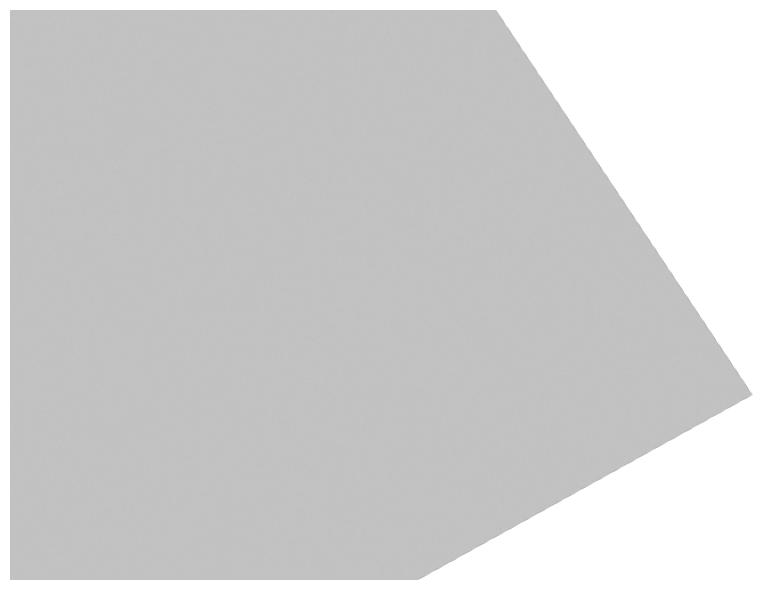

In [7]:
# The preview camera can be directly rendered as high-quality image
if not colab_compat:
    scene.render(camera="preview", num_samples=512);
else:
    print("Function not available in Colab mode.")

One can also render the image to a file as shown below:

In [8]:
render_to_file = False # Set to True to render image to file

# Render scene to file from preview viewpoint
if render_to_file:
    scene.render_to_file(camera="scene-cam-0", # Also try camera="preview"
                         filename="scene.png",
                         resolution=[650,500])

Instead of the preview camera, one can also specify dedicated cameras with different positions and `look_at` directions.

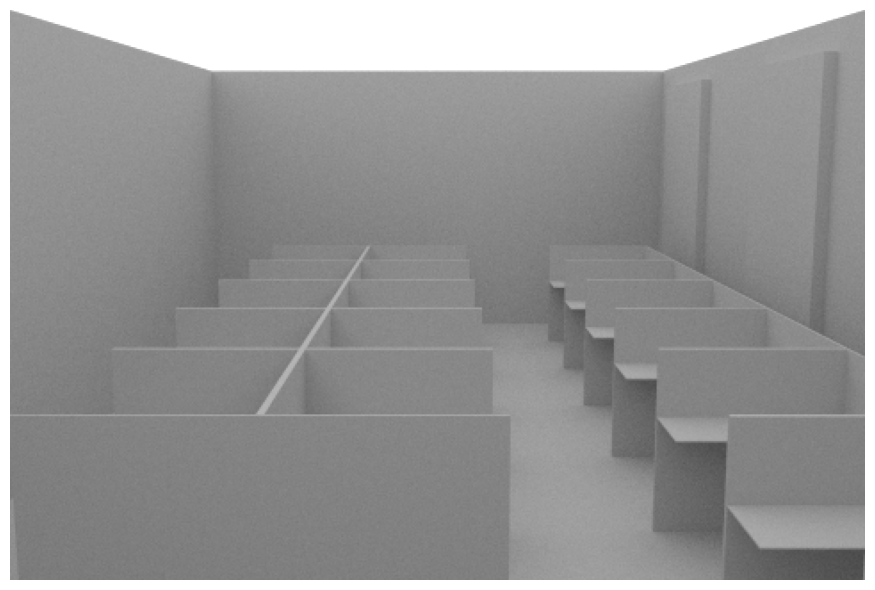

In [9]:
# Create new camera with different configuration
my_cam = Camera("my_cam16", position=[0,2.5,-7], look_at=[0,1,3], orientation=[0., 0., 0.])
scene.add(my_cam)

# Render scene with new camera*
scene.render(my_cam, resolution=resolution, num_samples=512); # Increase num_samples to increase image quality

Note that each [SceneObject](https://nvlabs.github.io/sionna/api/rt.html#scene-objects) (camera, transmitter,...) needs a unique name. Thus, running the cells above multiple times will lead to an error if the object name is not changed or the object is not removed from the scene.

## Ray Tracing for Radio Propagation

We need to configure transmitters and receivers prior to computing propagation paths between them. All transmitters and all receivers are equipped with the same antenna arrays which are defined by the `scene` properties `scene.tx_array` and `scene.rx_array`, respectively. Antenna arrays are composed of multiple identical antennas. Antennas can have custom or pre-defined patterns and are either single- or dual-polarized. One can add multiple transmitters and receivers to a scene which need to have unique names, a position, and orientation which is defined by yaw, pitch, and roll angles. 

In [10]:
print(scene.objects)

{'back': <sionna.rt.scene_object.SceneObject object at 0x7fdf04cc3d90>, 'desk': <sionna.rt.scene_object.SceneObject object at 0x7fdf04cc3b80>, 'floor': <sionna.rt.scene_object.SceneObject object at 0x7fdf04cc3ee0>, 'front': <sionna.rt.scene_object.SceneObject object at 0x7fdf04cc3f10>, 'wall_001': <sionna.rt.scene_object.SceneObject object at 0x7fdf04cc3f40>, 'windows': <sionna.rt.scene_object.SceneObject object at 0x7fdf04cc3f70>}


In [11]:
scene.get("back").radio_material = "itu_plywood" # "wall" is made of "itu_brick"
scene.get("desk").radio_material = "itu_plywood"
scene.get("floor").radio_material = "itu_concrete"
scene.get("front").radio_material = "itu_plywood"
scene.get("wall_001").radio_material = "itu_concrete"
scene.get("windows").radio_material = "itu_glass"

In [12]:
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(
                             num_rows=16,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=16,
                             num_cols=1,
                             vertical_spacing=0.1,
                             horizontal_spacing=0.1,
                             pattern="dipole",
                             polarization="V")

# Create transmitter
tx = Transmitter(name="tx",
                 position=[1,2,3],
                 orientation=[0,0,0]
                 )

# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name="rx",
              position=[-2,2,-3],
              orientation=[0,-3.141592653589793/2,0])

# Add receiver instance to scene
scene.add(rx)

#tx.look_at(rx)
# rx.look_at(tx) # Transmitter points towards receiver

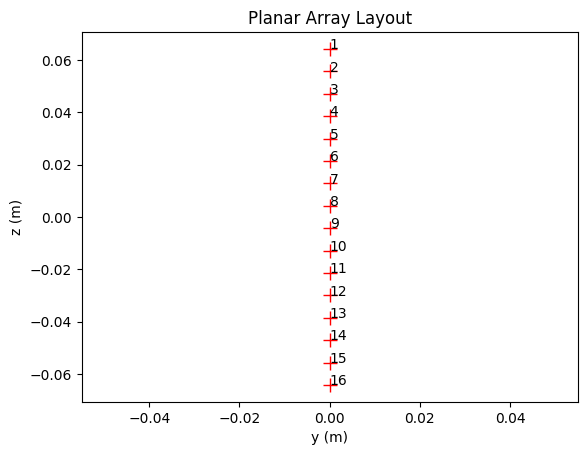

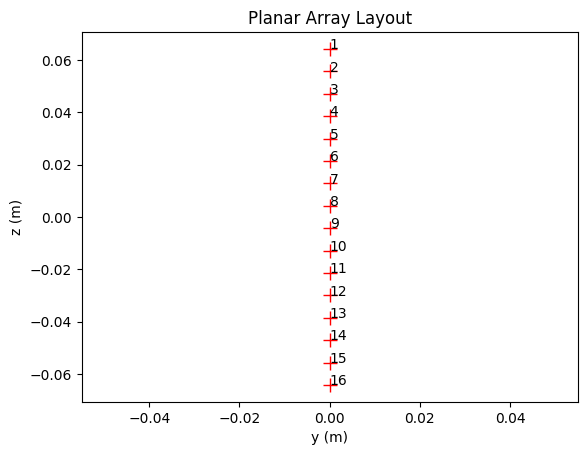

In [13]:
scene.rx_array.show()

Each [SceneObject](https://nvlabs.github.io/sionna/api/rt.html#scene-objects) has an assigned [RadioMaterial](https://nvlabs.github.io/sionna/api/rt.html#radio-materials) that describes the electromagnetic properties of the object whenever it interacts with a ray.
This behavior can be frequency-dependent and the ray tracing is done for a specific frequency.

We now set the carrier frequency of the scene and implicitly update all RadioMaterials.

In [14]:
scene.frequency = 5.71e9 # in Hz; implicitly updates RadioMaterials

scene.synthetic_array = False # If set to False, ray tracing will be done per antenna element (slower for large arrays)

The default scenes have RadioMaterials assigned to each scene object. However, the RadioMaterial of a specific object can be modified and customized by the user.

In [15]:
# Select an example object from the scene
# so = scene.get("Altes_Rathaus-itu_marble")

# Print name of assigned radio material for different frequenies
# for f in [3.5e9, 2.14e9]: # Print for differrent frequencies
    # scene.frequency = f
    # print(f"\nRadioMaterial: {so.radio_material.name} @ {scene.frequency/1e9:.2f}GHz")
    # print("Conductivity:", so.radio_material.conductivity.numpy())
    # print("Relative permittivity:", so.radio_material.relative_permittivity.numpy())
    # print("Complex relative permittivity:", so.radio_material.complex_relative_permittivity.numpy())
    # print("Relative permeability:", so.radio_material.relative_permeability.numpy())
    # print("Scattering coefficient:", so.radio_material.scattering_coefficient.numpy())
    # print("XPD coefficient:", so.radio_material.xpd_coefficient.numpy())

Let us run the ray tracing process and compute propagation paths between all transmitters and receivers. The parameter `max_depth` determines the maximum number of interactions between a ray and a scene objects. 
For example, with a `max_depth` of one, only LoS paths are considered. When the property `scene.synthetic_array` is set to `False`, antenna arrays are explicitly modeled by finding paths between any pair of transmitting and receiving antennas in the scene. Otherwise, arrays are represented by a single antenna located in the center of the array.
Phase shifts related to the relative antenna positions will then be applied based on a plane-wave assumption when the channel impulse responses are computed.

In [16]:
# Compute propagation paths
paths = scene.compute_paths(max_depth=1,
                            num_samples=1e5
                            
                            
                            )  # Number of rays shot into directions defined
                                              # by a Fibonacci sphere , too few rays can
                                              # lead to missing paths

# Visualize paths in the 3D preview
if colab_compat:
    scene.render("my_cam", paths=paths, show_devices=True, show_paths=True, resolution=resolution);
    raise ExitCell
scene.preview(paths, show_devices=True, show_paths=True) # Use the mouse to focus on the visualized paths

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [17]:
# scene.render("my_cam16", paths=paths, show_devices=True, show_paths=True, resolution=resolution);

*Remark*: only one preview instance can be opened at the same time. Please check the previous preview if no output appears.

The [Paths](https://nvlabs.github.io/sionna/api/rt.html#paths) object contains all paths that have been found between transmitters and receivers.
In principle, the existence of each path is determininistic for a given position and environment. Please note that due to the stochastic nature of the *shoot-and-bounce* algorithm, different runs of the `compute_paths` function can lead to different paths that are found. Most importantly, diffusely reflected or scattered paths are obtained through random sampling of directions after each interaction with a scene object. You can seet TensorFlow's random seed to a specific value before executing ``compute_paths`` to ensure reproducibility.

The Paths object contains detailed information about every found path and allows us to generated channel impulse responses and apply Doppler shifts for the simulation of time evolution.

Let us now inspect some of the available properties:

In [18]:
# Show the coordinates of the starting points of all rays.
# These coincide with the location of the transmitters.
print("Source coordinates: ", paths.sources.numpy())
print("Transmitter coordinates: ", list(scene.transmitters.values())[0].position.numpy())

# Show the coordinates of the endpoints of all rays.
# These coincide with the location of the receivers.
print("Target coordinates: ",paths.targets.numpy())
print("Receiver coordinates: ",list(scene.receivers.values())[0].position.numpy())

# Show the types of all paths:
# 0 - LoS, 1 - Reflected, 2 - Diffracted, 3 - Scattered
# Note that Diffraction and scattering are turned off by default.
print("Path types: ", paths.types.numpy())

Source coordinates:  [[1.        2.        3.1968865]
 [1.        2.        3.170635 ]
 [1.        2.        3.1443834]
 [1.        2.        3.1181319]
 [1.        2.        3.0918803]
 [1.        2.        3.0656288]
 [1.        2.        3.0393772]
 [1.        2.        3.0131257]
 [1.        2.        2.9868743]
 [1.        2.        2.9606228]
 [1.        2.        2.9343712]
 [1.        2.        2.9081197]
 [1.        2.        2.8818681]
 [1.        2.        2.8556166]
 [1.        2.        2.829365 ]
 [1.        2.        2.8031135]]
Transmitter coordinates:  [1. 2. 3.]
Target coordinates:  [[-2.0393772  2.        -3.       ]
 [-2.034127   2.        -3.       ]
 [-2.0288768  2.        -3.       ]
 [-2.0236263  2.        -3.       ]
 [-2.018376   2.        -3.       ]
 [-2.0131257  2.        -3.       ]
 [-2.0078754  2.        -3.       ]
 [-2.0026252  2.        -3.       ]
 [-1.9973749  2.        -3.       ]
 [-1.9921246  2.        -3.       ]
 [-1.9868742  2.        -3.     

We can see from the list of path types, that there are 14 paths in total. One LoS and 13 reflected paths.

In [19]:
print(paths.a.shape)
print(paths.tau.shape)
print(paths.theta_t.shape)

(1, 1, 16, 1, 16, 5, 1)
(1, 1, 16, 1, 16, 5)
(1, 1, 16, 1, 16, 5)


In [20]:
# We can now access for every path the channel coefficient, the propagation delay,
# as well as the angles of departure and arrival, respectively (zenith and azimuth).

# Let us inspect a specific path in detail
path_idx = 2 # Try out other values in the range [0, 13]

# For a detailed overview of the dimensions of all properties, have a look at the API documentation
print(f"\n--- Detailed results for path {path_idx} ---")
print(f"Channel coefficient: {paths.a[0,0,0,0,0,path_idx, 0].numpy()}")
print(f"Propagation delay: {paths.tau[0,0,0,0,0,path_idx].numpy()*1e6:.5f} us")
print(f"Zenith angle of departure: {paths.theta_t[0,0,0,0,0,path_idx]:.4f} rad")
print(f"Azimuth angle of departure: {paths.phi_t[0,0,0,0,0,path_idx]:.4f} rad")
print(f"Zenith angle of arrival: {paths.theta_r[0,0,0,0,0,path_idx]:.4f} rad")
print(f"Azimuth angle of arrival: {paths.phi_r[0,0,0,0,0,path_idx]:.4f} rad")


--- Detailed results for path 2 ---
Channel coefficient: (-9.464810136705637e-05+7.481378361262614e-06j)
Propagation delay: 0.00955 us
Zenith angle of departure: 2.2926 rad
Azimuth angle of departure: 0.0000 rad
Zenith angle of arrival: 0.8490 rad
Azimuth angle of arrival: -0.0000 rad


## From Paths to Channel Impulse Responses

Once paths are computed, they can be transformed into channel impulse responses (CIRs).
The class method [apply_doppler](https://nvlabs.github.io/sionna/api/rt.html#Paths.apply_doppler) can simulate time evolution of the CIR based on arbitrary velocity vectors of all transmitters and receivers for a desired sampling frequency and number of time steps. 
The class method [cir](https://nvlabs.github.io/sionna/api/rt.html#Paths.cir) generates the channel impulse responses which can be used by other components for link-level simulations in either time or frequency domains. The method also allows you to only consider certain types of paths, e.g., line-of-sight, reflections, etc.

In [21]:
# Default parameters in the PUSCHConfig
subcarrier_spacing = 312.5e3
fft_size = 48

In [22]:
a, tau = paths.cir()
print("Shape of cir: ", a.shape)
print("Shape of tau: ", tau.shape)

Shape of cir:  (1, 1, 16, 1, 16, 5, 1)
Shape of tau:  (1, 1, 16, 1, 16, 5)


In [23]:
# Print shape of channel coefficients before the application of Doppler shifts
# The last dimension corresponds to the number of time steps which defaults to one
# as there is no mobility
print("Shape of `a` before applying Doppler shifts: ", paths.a.shape)

# Apply Doppler shifts
# paths.apply_doppler(sampling_frequency=subcarrier_spacing, # Set to 15e3 Hz
#                     num_time_steps=14, # Number of OFDM symbols
#                     tx_velocities=[0,0,0], # We can set additional tx speeds
#                     rx_velocities=[0,0,0]) # Or rx speeds

# print("Shape of `a` after applying Doppler shifts: ", paths.a.shape)

# a, tau = paths.cir()
# print("Shape of tau: ", tau.shape)

Shape of `a` before applying Doppler shifts:  (1, 1, 16, 1, 16, 5, 1)


Let us have a look at the channel impulse response for the 14 incoming paths from the simulation above.

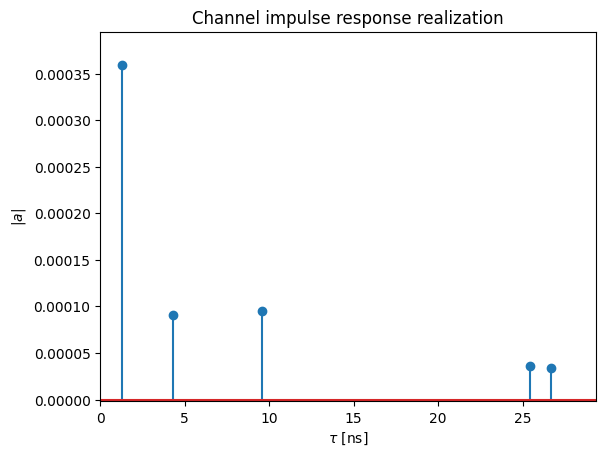

In [24]:
t = tau[0,0,0,0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,0,:,0]
a_max = np.max(a_abs)
# Add dummy entry at start/end for nicer figure
t = np.concatenate([(0.,), t, (np.max(t)*1.1,)])
a_abs = np.concatenate([(np.nan,), a_abs, (np.nan,)])

# And plot the CIR
plt.figure()
plt.title("Channel impulse response realization")

plt.stem(t, a_abs)
plt.xlim([0, np.max(t)])
plt.ylim([-2e-6, a_max*1.1])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");

Note that the delay of the first arriving path is normalized to zero. This behavior can be changed using the Paths' call property ``normalize_delays``. For link-level simulations, it is recommended to work with normalized delays, unless perfect synchronization is explicitly desired.

In [25]:
# Disable normalization of delays
paths.normalize_delays = False

# Get only the LoS path
_, tau = paths.cir(los=True, reflection=False)
print("Delay of first path without normalization: ", np.squeeze(tau))

#paths.normalize_delays = True
#_, tau = paths.cir(los=True, reflection=False)
#print("Delay of first path with normalization: ", np.squeeze(tau))

Delay of first path without normalization:  [[2.3022984e-08 2.2944398e-08 2.2865878e-08 2.2787422e-08 2.2709035e-08
  2.2630713e-08 2.2552459e-08 2.2474273e-08 2.2396161e-08 2.2318115e-08
  2.2240142e-08 2.2162238e-08 2.2084411e-08 2.2006653e-08 2.1928969e-08
  2.1851362e-08]
 [2.3015279e-08 2.2936666e-08 2.2858119e-08 2.2779634e-08 2.2701220e-08
  2.2622872e-08 2.2544590e-08 2.2466377e-08 2.2388237e-08 2.2310164e-08
  2.2232163e-08 2.2154234e-08 2.2076375e-08 2.1998590e-08 2.1920879e-08
  2.1843240e-08]
 [2.3007582e-08 2.2928944e-08 2.2850369e-08 2.2771859e-08 2.2693419e-08
  2.2615044e-08 2.2536735e-08 2.2458496e-08 2.2380327e-08 2.2302226e-08
  2.2224196e-08 2.2146239e-08 2.2068352e-08 2.1990539e-08 2.1912799e-08
  2.1835131e-08]
 [2.2999895e-08 2.2921231e-08 2.2842631e-08 2.2764095e-08 2.2685628e-08
  2.2607225e-08 2.2528889e-08 2.2450623e-08 2.2372426e-08 2.2294298e-08
  2.2216240e-08 2.2138254e-08 2.2060339e-08 2.1982499e-08 2.1904729e-08
  2.1827034e-08]
 [2.2992223e-08 2.291353

The CIRs can now be loaded either in the time-domain or frequency-domain channel models, respectively.
Please see [cir_to_ofdm_channel](https://nvlabs.github.io/sionna/api/channel.wireless.html#sionna.channel.cir_to_ofdm_channel) and [cir_to_time_channel](https://nvlabs.github.io/sionna/api/channel.wireless.html#sionna.channel.cir_to_time_channel) for further details.

In [26]:
# Compute frequencies of subcarriers and center around carrier frequency
frequencies = subcarrier_frequencies(fft_size, subcarrier_spacing)
print("frequencies: ", frequencies)
print("a: ", a.shape)
# Compute the frequency response of the channel at frequencies.
h_freq = cir_to_ofdm_channel(frequencies,
                             a,
                             tau,
                             normalize=False) # Non-normalized includes path-loss

# Verify that the channel power is normalized
h_avg_power = tf.reduce_mean(tf.abs(h_freq)**2).numpy()

print("Shape of h_freq: ", h_freq.shape)
print("Average power h_freq: ", h_avg_power) # Channel is normalized
print("h_freq: ", np.squeeze(h_freq).shape)

frequencies:  tf.Tensor(
[-7500000. -7187500. -6875000. -6562500. -6250000. -5937500. -5625000.
 -5312500. -5000000. -4687500. -4375000. -4062500. -3750000. -3437500.
 -3125000. -2812500. -2500000. -2187500. -1875000. -1562500. -1250000.
  -937500.  -625000.  -312500.        0.   312500.   625000.   937500.
  1250000.  1562500.  1875000.  2187500.  2500000.  2812500.  3125000.
  3437500.  3750000.  4062500.  4375000.  4687500.  5000000.  5312500.
  5625000.  5937500.  6250000.  6562500.  6875000.  7187500.], shape=(48,), dtype=float32)
a:  (1, 1, 16, 1, 16, 5, 1)
Shape of h_freq:  (1, 1, 16, 1, 16, 1, 48)
Average power h_freq:  1.5865203e-07
h_freq:  (16, 16, 48)


The frequency responses `h_freq` are now ready to be processed by the [ApplyOFDMChannel](https://nvlabs.github.io/sionna/api/channel.wireless.html#sionna.channel.ApplyOFDMChannel) Layer.

In [27]:
# Placeholder for tx signal of shape
# [batch size, num_tx, num_tx_ant, num_ofdm_symbols, fft_size]
x = tf.zeros([h_freq.shape.as_list()[i] for i in [0,3,4,5,6]], tf.complex64)

no = 0.1 # noise variance

# Init channel layer
channel = ApplyOFDMChannel(add_awgn=True)

# Apply channel
y = channel([x, h_freq, no])

# [batch size, num_rx, num_rx_ant, num_ofdm_symbols, fft_size]
print(y.shape)

(1, 1, 16, 1, 48)


In [28]:
type(h_freq)

tensorflow.python.framework.ops.EagerTensor

In [29]:
savemat('csi06.mat',{'h_freq':np.squeeze(h_freq)})